# ---------------------------- #
# 1. Pascal VOC Conversion and Data Preparation
# ---------------------------- #

# **Imoporting Libraries**

In [6]:
pip install "numpy<2"

In [8]:
import os
import sys
import tarfile
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# **Converting text file into dataframe**

In [11]:
path = 'C:/Users/mihir/Downloads/archive/agri_data/data'
data = [os.path.join(path, x) for x in os.listdir(path)]
images = [x for x in data if x.endswith('.jpeg')]
labels = [x for x in data if x.endswith('.txt')]

# **Display a Sample image**

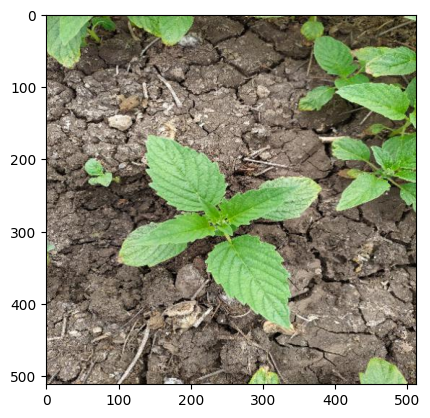

In [14]:
plt.imshow(cv2.cvtColor(cv2.imread(images[50]), cv2.COLOR_BGR2RGB))
plt.show()

# **Creating a dataframe from the labels**

In [17]:
df_list = []
for img_path in tqdm(images):
    label_path = img_path[:-5] + '.txt'
    with open(label_path, 'r') as file:
        labels = file.read().strip().split('\n')

    for label in labels:
        obj_id, x_cen, y_cen, w, h = map(float, label.split())
        df_list.append({
            'image_name': img_path[len(path):],
            'object': int(obj_id),
            'x_cen': x_cen,
            'y_cen': y_cen,
            'w': w,
            'h': h
        })

df = pd.DataFrame(df_list)
print(df.head())

100%|██████████| 1300/1300 [00:08<00:00, 145.67it/s]


          image_name  object     x_cen     y_cen         w         h
0  \agri_0_1009.jpeg       1  0.608398  0.498047  0.541016  0.531250
1  \agri_0_1017.jpeg       1  0.496094  0.384766  0.960938  0.753906
2  \agri_0_1018.jpeg       1  0.445312  0.483398  0.808594  0.634766
3  \agri_0_1020.jpeg       1  0.494141  0.350586  0.730469  0.611328
4  \agri_0_1024.jpeg       1  0.601562  0.448242  0.570312  0.595703


# **Converting dataframe into Pascal-voc format**

In [20]:
column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
pascal_voc = pd.DataFrame(columns=column_name)

for i in tqdm(range(len(df))):
    pascal_voc.loc[i, 'filename'] = df.loc[i, 'image_name']
    pascal_voc.loc[i, 'width'] = 512
    pascal_voc.loc[i, 'height'] = 512
    pascal_voc.loc[i, 'class'] = 'crop' if df.loc[i, 'object'] == 0 else 'weed'
    pascal_voc.loc[i, 'xmin'] = int((df.loc[i, 'x_cen'] - df.loc[i, 'w'] / 2) * 512)
    pascal_voc.loc[i, 'ymin'] = int((df.loc[i, 'y_cen'] - df.loc[i, 'h'] / 2) * 512)
    pascal_voc.loc[i, 'xmax'] = int((df.loc[i, 'x_cen'] + df.loc[i, 'w'] / 2) * 512)
    pascal_voc.loc[i, 'ymax'] = int((df.loc[i, 'y_cen'] + df.loc[i, 'h'] / 2) * 512)

print(pascal_voc.head())

100%|██████████| 2072/2072 [00:04<00:00, 498.95it/s]

            filename width height class xmin ymin xmax ymax
0  \agri_0_1009.jpeg   512    512  weed  172  119  449  391
1  \agri_0_1017.jpeg   512    512  weed    8    4  500  390
2  \agri_0_1018.jpeg   512    512  weed   20   84  434  409
3  \agri_0_1020.jpeg   512    512  weed   66   23  440  336
4  \agri_0_1024.jpeg   512    512  weed  161   76  453  381


# **Visualizing labels**

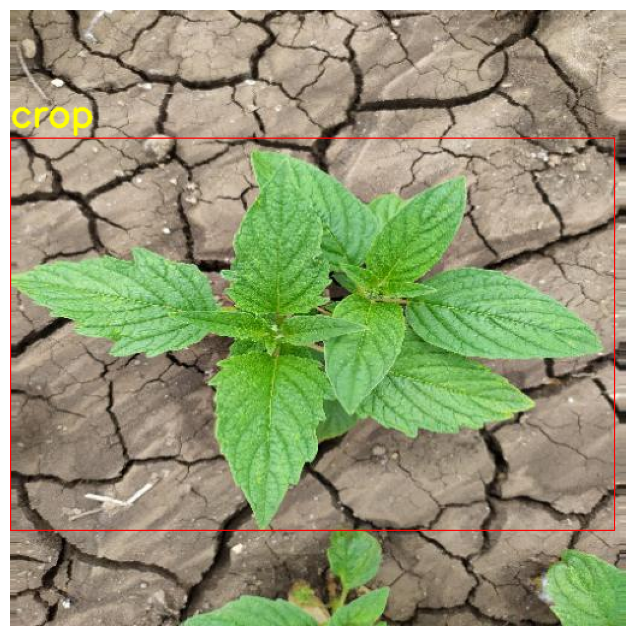

In [33]:
any_index_number = 50  # Change this number for different images
test_img = cv2.cvtColor(cv2.imread(path + pascal_voc.loc[any_index_number, 'filename']), cv2.COLOR_BGR2RGB)
test_df = pascal_voc[pascal_voc['filename'] == pascal_voc.loc[any_index_number, 'filename']].reset_index(drop=True)

for i in range(len(test_df)):
    cv2.rectangle(test_img, (test_df.loc[i, 'xmin'], test_df.loc[i, 'ymin']),
                  (test_df.loc[i, 'xmax'], test_df.loc[i, 'ymax']), (255, 0, 0), 1)
    cv2.putText(test_img, test_df.loc[i, 'class'], (test_df.loc[i, 'xmin'], test_df.loc[i, 'ymin'] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)

plt.figure(figsize=(8, 8))
plt.imshow(test_img)
plt.axis('off')
plt.show()

In [35]:
"""# Saving label file"""

pascal_voc.to_csv('pascal_voc_format.csv', index=False)

# ---------------------------- #
# 2. MobileNetV2 Model Training and Evaluation
# ---------------------------- #

In [38]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter as tk
from tkinter import filedialog

# Load the data

In [41]:
df = pd.read_csv('pascal_voc_format.csv')

# Create a new column 'label' in the dataframe

In [44]:

df['label'] = df['class'].apply(lambda x: 0 if x == 'crop' else 1)

# Split the data into training and testing sets

In [46]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create a MobileNetV2 model

In [49]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers

In [52]:

for layer in base_model.layers:
    layer.trainable = False

# Add a new classification head

In [55]:

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model

In [58]:

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model

In [61]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a function to load and preprocess images

In [64]:

def load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Train the model

In [39]:

train_images = []
train_labels = []
for index, row in train_df.iterrows():
    img_path = 'C:/Users/mihir/Downloads/archive/agri_data/data' + row['filename']
    img_array = load_image(img_path)
    train_images.append(img_array)
    train_labels.append(row['label'])

train_images = np.concatenate(train_images, axis=0)
train_labels = np.array(train_labels)

model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9841 - loss: 0.0588 - val_accuracy: 0.9578 - val_loss: 0.2316
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9880 - loss: 0.0270 - val_accuracy: 0.9307 - val_loss: 0.3748
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 63s 832ms/step - accuracy: 0.9773 - loss: 0.0854 - val_accuracy: 0.9428 - val_loss: 0.3173
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 787ms/step - accuracy: 0.9840 - loss: 0.0457 - val_accuracy: 0.9518 - val_loss: 0.2875
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 702ms/step - accuracy: 0.9895 - loss: 0.0209 - val_accuracy: 0.9669 - val_loss: 0.2513
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 695ms/step - accuracy: 0.9951 - loss: 0.0150 - val_accuracy: 0.9639 - val_loss: 0.2506
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 904ms/step - accuracy: 0.9920 - loss: 0.0178 - val_accuracy: 0.9518 - val_loss: 0.3154
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9933 - loss: 0.0178 - val_accuracy: 0.9

# Evaluate the model

In [40]:

test_images = []
test_labels = []
for index, row in test_df.iterrows():
    img_path = 'C:/Users/mihir/Downloads/archive/agri_data/data' + row['filename']
    img_array = load_image(img_path)
    test_images.append(img_array)
    test_labels.append(row['label'])

test_images = np.concatenate(test_images, axis=0)
test_labels = np.array(test_labels)

loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {accuracy:.2f}')


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 517ms/step - accuracy: 0.9892 - loss: 0.1180
Test accuracy: 0.98


# Evaluate the model on the test data

In [42]:

test_pred = model.predict(test_images)
test_pred_class = (test_pred > 0.5).astype('int32')

# Calculate the accuracy, precision, F1 score, and confusion matrix
accuracy = accuracy_score(test_labels, test_pred_class)
precision = precision_score(test_labels, test_pred_class)
f1 = f1_score(test_labels, test_pred_class)
conf_mat = confusion_matrix(test_labels, test_pred_class)

13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step


# Confusion Matrix

In [44]:
print(f'Test accuracy: {accuracy:.2f}')
print(f'Test precision: {precision:.2f}')
print(f'Test F1 score: {f1:.2f}')
print('Confusion matrix:')
print(conf_mat)

Test accuracy: 0.98
Test precision: 0.98
Test F1 score: 0.98
Confusion matrix:
[[226   3]
 [  4 182]]


# Plot the confusion matrix

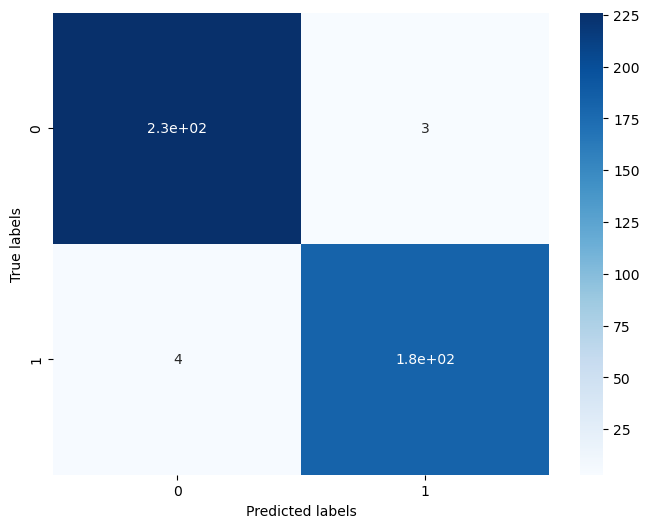

In [46]:

plt.figure(figsize=(8 , 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Print the classification report

In [48]:

print('Classification report:')
print(classification_report(test_labels, test_pred_class))

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       229
           1       0.98      0.98      0.98       186

    accuracy                           0.98       415
   macro avg       0.98      0.98      0.98       415
weighted avg       0.98      0.98      0.98       415



# ---------------------------- #
# 3. ResNet50 Model Training and Evaluation
# ---------------------------- #

In [51]:
from tensorflow.keras.applications import ResNet50

# Define the ResNet50 model

In [53]:

base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the ResNet50 base model layers

In [55]:

for layer in base_model_resnet.layers:
    layer.trainable = False

# Add a new classification head to ResNet50

In [57]:

x_resnet = base_model_resnet.output
x_resnet = GlobalAveragePooling2D()(x_resnet)
x_resnet = Dense(1024, activation='relu')(x_resnet)
predictions_resnet = Dense(1, activation='sigmoid')(x_resnet)

# Create the ResNet50 model

In [59]:

resnet_model = Model(inputs=base_model_resnet.input, outputs=predictions_resnet)

# Compile the ResNet50 model

In [61]:

resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the ResNet50 model on the training data

In [69]:

history_resnet = resnet_model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9140 - loss: 0.2212 - val_accuracy: 0.9277 - val_loss: 0.2282
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9311 - loss: 0.2037 - val_accuracy: 0.9367 - val_loss: 0.2118
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9514 - loss: 0.1416 - val_accuracy: 0.9367 - val_loss: 0.1897
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9614 - loss: 0.1412 - val_accuracy: 0.9458 - val_loss: 0.1816
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9667 - loss: 0.1381 - val_accuracy: 0.9367 - val_loss: 0.1990
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9547 - loss: 0.1381 - val_accuracy: 0.9518 - val_loss: 0.1732
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9722 - loss: 0.1135 - val_accuracy: 0.9277 - val_loss: 0.1985
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9693 - loss: 0.1137 - val_accuracy: 0.9247 - val_loss:

# Evaluate the ResNet50 model on the test data

In [71]:

loss_resnet, accuracy_resnet = resnet_model.evaluate(test_images, test_labels)
print(f'ResNet50 Test accuracy: {accuracy_resnet:.2f}')


13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9683 - loss: 0.1271
ResNet50 Test accuracy: 0.95


# Plotting Training and Validation Accuracy and Loss for ResNet50

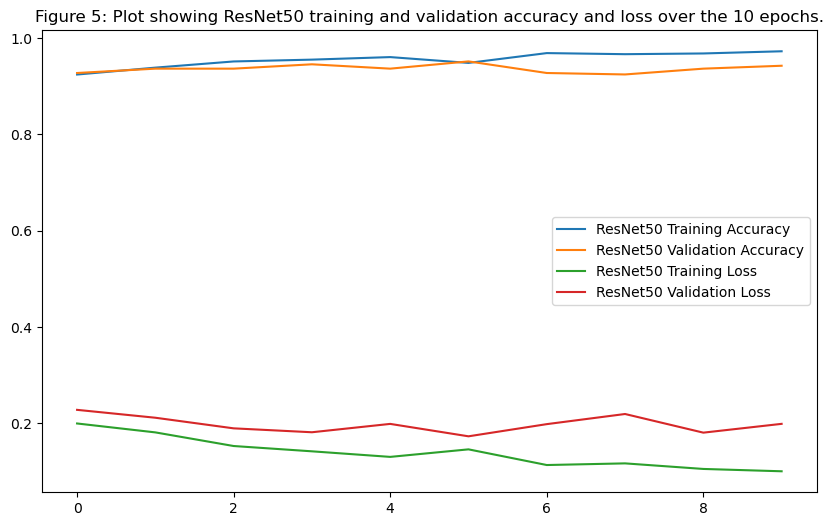

In [74]:

plt.figure(figsize=(10, 6))
plt.plot(history_resnet.history['accuracy'], label='ResNet50 Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet50 Validation Accuracy')
plt.plot(history_resnet.history['loss'], label='ResNet50 Training Loss')
plt.plot(history_resnet.history['val_loss'], label='ResNet50 Validation Loss')
plt.legend()
plt.title('Figure 5: Plot showing ResNet50 training and validation accuracy and loss over the 10 epochs.')
plt.show()

# Evaluate the ResNet50 model on test data and calculate metrics

In [77]:

test_pred_resnet = resnet_model.predict(test_images)
test_pred_class_resnet = (test_pred_resnet > 0.5).astype('int32')

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


# Calculate accuracy, precision, F1 score, and confusion matrix for ResNet50

In [79]:

accuracy_resnet = accuracy_score(test_labels, test_pred_class_resnet)
precision_resnet = precision_score(test_labels, test_pred_class_resnet)
f1_resnet = f1_score(test_labels, test_pred_class_resnet)
conf_mat_resnet = confusion_matrix(test_labels, test_pred_class_resnet)

print(f'ResNet50 Test accuracy: {accuracy_resnet:.2f}')
print(f'ResNet50 Test precision: {precision_resnet:.2f}')
print(f'ResNet50 Test F1 score: {f1_resnet:.2f}')
print('Confusion matrix for ResNet50:')
print(conf_mat_resnet)


ResNet50 Test accuracy: 0.95
ResNet50 Test precision: 0.93
ResNet50 Test F1 score: 0.94
Confusion matrix for ResNet50:
[[215  14]
 [  7 179]]


# Plot the confusion matrix for ResNet50

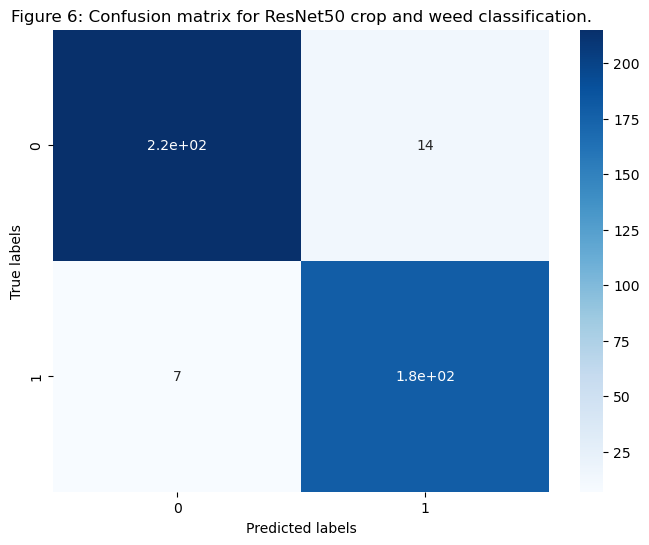

In [81]:

plt.figure(figsize=(8 , 6))
sns.heatmap(conf_mat_resnet, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Figure 6: Confusion matrix for ResNet50 crop and weed classification.')
plt.show()

# ---------------------------- #
# 4. File Classifier GUI for Image Prediction
# ---------------------------- #

# Use the model to classify a new image

In [84]:

def classify_image(img_path):
    img_array = load_image(img_path)
    prediction = model.predict(img_array)
    if prediction[0][0] < 0.5:
        return 'crop'
    else:
        return 'weed'

# Create a GUI with a file dialog

In [86]:
def select_file():
    root = tk.Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(title="Select an image file", filetypes=[("Image files", ".jpg .jpeg .png .bmp")])
    return file_path

# Classify the selected image

In [88]:
def classify_selected_image():
    img_path = select_file()
    if img_path:
        print(f'The image is a {classify_image(img_path)}')
    else:
        print("No image selected")

# Call the function to classify the selected image

In [96]:

classify_selected_image()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
The image is a crop


In [100]:
# Save your model in the new Keras format
model.save("C:/Users/mihir/Desktop/Crop and weed detection/crop_weed_model.keras")


In [110]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test_labels, test_pred_resnet)
print(f'ROC-AUC Score: {roc_auc:.2f}')


ROC-AUC Score: 0.98
